# Spatio-Temporal Accessibility of Pharmacy Care in Vermont, USA

## Alternative Study Versions

### Authors

- Sam Roubin, sroubin@middlebury.edu, https://orcid.org/0009-0005-5490-3744, Middlebury College
- Joseph Holler\*, josephh@middlebury.edu, https://orcid.org/0000-0002-2381-2699, Middlebury College
- Peter Kedron, peterkedron@ucsb.edu, https://orcid.org/0000-0002-1093-3416, University of California, Santa Barbara

\* Corresponding author

## **Materials and procedure**

### Computational environment

Similar to Kang et al. (2020), this study was run using CyberGIS-Jupyter. This study uses an updated software environment from the reproduction study, using Python Jupyter Notebooks in the CyberGISX environment available at https://cybergisxhub.cigi.illinois.edu/. In particular, we use the Python 3-0.9.0 Kernel running Python 3.8.12, pandas 1.3.5, geopandas 0.10.2, networkx 2.6.3 and osmnx 1.1.2. 


In [4]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import os
import time
import warnings
import IPython
import requests
from IPython.display import display, clear_output
from shapely.ops import nearest_points   #for pharmacy_setting function
from scipy.stats import kruskal
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as path_effects
from tabulate import tabulate
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Patch
import imageio
import math

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
seaborn==0.11.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
IPython==8.3.0
requests==2.27.1
imageio==2.13.5


In [5]:
!pip install scikit-posthocs -q
import scikit_posthocs as sp

### Check Directories

In [6]:
# Check working directory
os.getcwd()

'/home/jovyan/work/OR-VT-Pharmacy/procedure/code'

In [7]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'/home/jovyan/work/OR-VT-Pharmacy'

### Study parameters

*Distance*: This study was first conducted using `10`, `20`, and `30` minute distance travel time thresholds.

*Friction of distance* is determined by a gaussian function and beta coefficient. The study first used a beta coefficient of `262` and discretized a weight to each distance band according to the `minimum` travel time of the band.

*Time*: This study was first conducted based on data on 192 pharmacies through `December 2023`.
Since that time, three community pharmacies have opened in Vermont and eleven pharmacies have closed in Vermont. 
This number includes four Rite Aid locations slated for closure or sale later this year.
We have not tracked pharmacy openings and closings outside of the state.
Below, use a status year of 2023 to generate results as of December 2023 and 2025 to generate results as of `June 2025`.

*Pharmacy Technicians*: This study began with a working assumption that one pharmacy technician adds the equivalent level of services to a community pharmacy as that of `pt5` or `0.5` pharmacists. This variable can be adjusted with an alternative FTE.

*Demand Population*: This study began studying the total population. It can be varied by studying alternative subsets of the population, e.g. those aged 65 and above.

*Geography Level*: The study initially used county subdivisions for population data. Alternatively, change to census `blocks` for a finer-grained analysis.

In [22]:
# Set a unique ID for the set of results
setID_file = "./data/derived/public/result_sets/setID.txt"

with open(setID_file, 'r') as f:
    last_id = int(f.read().strip())
setID = str(last_id + 1).zfill(3)
with open(setID_file, 'w') as f:
    f.write(setID)

# beta coefficient
beta = 262
# discretization preference: min or mean
discretize = "min"
# define three distances in minutes in ascending order 
dist_mins = [10, 20, 30]

# calculate distance thresholds in seconds and distance weights
distances = [i * 60 for i in dist_mins]

def dist_weight(dist, beta):
    result = math.exp(-(dist ** 2) / beta)
    return round(result, 2)

# calculate distance weights
if discretize == "min":
    weights = [1]
    for d in dist_mins[:-1]:
        weights.append(dist_weight(d, beta))
elif discretize == "mean":
    weights = []
    for ind in range(len(dist_mins)):
        if ind == 0:
            weights.append(1)
        else:
            dist = (dist_mins[ind-1] + dist_mins[ind]) / 2
            weights.append(dist_weight(dist, beta))
            
# set status year to "2023" or "2025" for pharmacies as of December 2023 or June 2025
# or to 'closed' to vizualize closed pharmacies
temporal_extent = "2023"

# set the techFTE to the pharmacist full-time equivalent value of a pharmacy technician
techFTE = 0.5
tech_ratio = "pt" + str(int(techFTE * 10))

# switch from total_pop to other population variables, e.g. elderly_pop
demand_population = "total_pop"

# switch from county_subdivision to block to calculate at the block level
geog_level = "county_subdivision"

# save figures? Switch to True to save figures
figsave = True
def make_fig_file(fignum):
    fig_folder = "./results/figures/set_" + setID
    os.makedirs(fig_folder, exist_ok=True)
    return fig_folder + "/figure" + str(fignum) + ".jpg"

setDesc = "Result Set ID: " + setID + "\n" + \
          "Beta: " + str(beta) + "\n" + \
          "Discretization: " + discretize + " travel time" + "\n" + \
          "Distances: " + str(distances) + " (seconds) " + str(dist_mins) + " (minutes)" + "\n" + \
          "Weights: " + str(weights) + "\n" + \
          "Time series: " + temporal_extent + "\n" + \
          "Pharmacy technician value: " + tech_ratio + " (" + str(techFTE) + ")" + "\n" + \
          "Demand population: " + demand_population + "\n" + \
          "Geographic level of aggregation: " + geog_level

setDesc_file = "./data/derived/public/result_sets/results_" + setID + ".txt"

with open(setDesc_file, 'w') as f:
    f.write(setDesc)

print(setDesc)

Result Set ID: 011
Beta: 262
Discretization: min travel time
Distances: [600, 1200, 1800] (seconds) [10, 20, 30] (minutes)
Weights: [1, 0.68, 0.22]
Time series: 2023
Pharmacy technician value: pt5 (0.5)
Demand population: total_pop
Geographic level of aggregation: county_subdivision


### Load Pharmacy Data

In [23]:
pharmacies = gpd.read_file('./data/raw/public/pharmacy/pharmacies_df.gpkg')
pharm_staffing = pd.read_csv('./data/raw/private/staffing_interpolated.csv')
pharmacies_df = pd.merge(pharmacies, pharm_staffing, on='pharmid', how = 'left')

### Load Population Data

First, load county subdivisions and their NECTA classifications.  
Second, load census blocks.

In [24]:
# Read in population data by town
population_df = gpd.read_file('./data/derived/public/population/county_subdivisions.gpkg')

# Read in metropolitan / micropolitan classifications (NECTAS)
nectas_df =  gpd.read_file('./data/raw/public/population/nectas.csv')
nectas_df['GEOID'] = nectas_df['fips_state'] + nectas_df['fips_county'] + nectas_df['fips_subdivision']

# Join NECTAS classifications to population data with subdivision and county FIPS
pop_df = pd.merge(population_df, nectas_df[['GEOID', 'necta']], on=['GEOID'], how = 'left')

# Save as geopackage into public/derived
if False:
    pop_df.to_file('./data//derived/public/population/county_subdivisions_necta.gpkg', driver='GPKG')

# pop_df.head()

<AxesSubplot:>

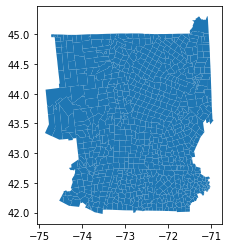

In [25]:
# All geometries for which we have obtained population data
pop_df.plot()

<AxesSubplot:>

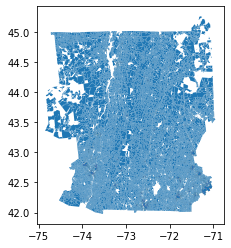

In [26]:
# Read in population data by block
blocks25 = gpd.read_file('./data/derived/public/population/blocks25.gpkg')
blocks33 = gpd.read_file('./data/derived/public/population/blocks33.gpkg')
blocks36 = gpd.read_file('./data/derived/public/population/blocks36.gpkg')
blocks50 = gpd.read_file('./data/derived/public/population/blocks50.gpkg')
blocks_df = pd.concat([blocks25, blocks33, blocks36, blocks50])
blocks_df.plot()

In [27]:
# Reproject to VT state plane
pop_df.to_crs("EPSG:6589", inplace = True)
blocks_df.to_crs("EPSG:6589", inplace = True)

### Load the Road Network

Load a processed road network.  
Then, create a geodataframe of its nodes and construct a point geography for each node from its x and y coordinates.  
Finally, drop four nodes at the end of one-way roads, causing routing errors.

In [28]:
roads_processsed_path = "./data/derived/private/roads_processed.graphml"
# load the processed network graph
if os.path.exists(roads_processsed_path):
    print("Loading road network from", roads_processsed_path, "Please wait...", flush=True)
    G = ox.load_graphml(roads_processsed_path) 
    print("Data loaded.") 
    
else:
    print("Error: could not load the road network from file.")

Loading road network from ./data/derived/private/roads_processed.graphml Please wait...
Data loaded.


In [29]:
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

# Create point geometries for each node in the graph, to make constructing catchment area polygons easier
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])

# Drop four dead-end nodes for parking lot entrances
nodes.drop([205007938, 5976921845, 204567135, 61755372], inplace = True)

Find the nearest node to each pharmacy

In [30]:
nodes_osmid = gpd.GeoDataFrame(nodes[["geometry"]]).reset_index().set_crs(epsg=4326, inplace=True)
# print(nodes_osmid.head())

pharmacies_osm = gpd.sjoin_nearest(pharmacies_df, nodes_osmid, distance_col="distances")

#rename column from osmid to nearest_osm, so that it works with other code
pharmacies_osm = pharmacies_osm.rename(columns={"osmid": "nearest_osm"})

## **Analysis**

### Calculate catchment areas

In [31]:
# initialize catchment list, composed of 3 empty geodataframes for 3 distance bands
catchments = []
for distance in distances:
    catchments.append(gpd.GeoDataFrame())
    
# initialize results geodataframe to store final catchment areas
results = gpd.GeoDataFrame(columns = ["geometry","pharmid","weight"], crs = "EPSG:4326", geometry = "geometry")

rweights = weights[::-1]
rdistances = distances[::-1]
print(rweights)
print(rdistances)

# calculate catchment areas
print("Working on pharmacy:")
for ind in pharmacies_osm.index:
    print(str(ind + 1) + "/" + str(len(pharmacies_osm)), end = '\r')
    
    # create dictionary of nearest nodes
    nearest_nodes = nx.single_source_dijkstra_path_length(G, pharmacies_osm['nearest_osm'][ind], rdistances[0], "travel_time") # creating the largest graph from which 10 and 20 minute drive times can be extracted from

    # convert to a dataframe and join to nodes on the index (OSMID) to combine geographies with time (z)
    nearest_points = pd.DataFrame.from_dict(nearest_nodes, orient='index').rename(columns = {0: 'z' } )
    points = pd.merge(nodes, nearest_points, left_index=True, right_index=True, how='inner')

    polygons = []
    for d in range(len(rdistances)):
        points = points.query("z <= " + str(rdistances[d]))
        convex_hull = gpd.GeoDataFrame(gpd.GeoSeries(points.unary_union.convex_hull))
        convex_hull = convex_hull.rename(columns={0:'geometry'}).set_geometry('geometry')
        convex_hull["weight"] = rweights[d]
        polygons.append(convex_hull)
        if d > 0:
            polygons[d-1] = gpd.overlay(polygons[d-1], polygons[d], how = "difference")
    
    polygonsgdf = pd.concat(polygons)
    polygonsgdf.set_crs(crs="EPSG:4326", inplace=True)    
    polygonsgdf["pharmid"] = pharmacies_osm['pharmid'][ind]
    results = pd.concat([results, polygonsgdf])

[0.22, 0.68, 1]
[1800, 1200, 600]
Working on pharmacy:


In [32]:
print(len(pharmacies_osm), "pharmacies and", len(results), "polygons for", len(results) / len(pharmacies_osm), "polygons per pharmacy") 

195 pharmacies and 585 polygons for 3.0 polygons per pharmacy


In [33]:
catchment_results_file = "./data/derived/public/catchments.gpkg"
# set to True to save the file
if False:
    results.to_file(catchment_results_file)
    
# set to True to load the catchments file
if False:
    results = gpd.read_file(catchment_results_file)

The interactive map below shows the three catchment areas for each pharmacy in our study area.
We check for completeness by counting the catchment areas and dividing by the total number of pharmacies, expecting a value of 3 catchment areas per pharmacy.

In [34]:
results.explore("weight", categorical=True, cmap='GnBu', style_kwds={'fillOpacity': 0.2})
# try results.explore("weight")

### Service-to-population ratio calculations
To begin the process of calulating service-to-population ratios, town areas must be calculated since this is the final geographic unit we want to display our results in.
This code calculates the areas where catchment areas overlap with different town geometries (fragments), and then estimates the population within these fragments by assessing the proportion of each town covered by a specific fragment.
Next, these fragments are assigned weights based on the distance to a pharmacy location, culminating in an estimated population that may use services in a given pharmacy location.

In [35]:
# Reproject catchment results to VT State Plane
results.to_crs("EPSG:6589", inplace = True)

In [36]:
%%time
# Calculate population areas and overlay with catchments
# (fragments are where each individual catchment area overlaps with a different population area)
if geog_level == 'block':
    blocks_df['src_area'] = blocks_df.geometry.area
    fragments = gpd.overlay(blocks_df, results, how = 'intersection')
else:
    pop_df['src_area'] = pop_df.geometry.area
    fragments = gpd.overlay(pop_df, results, how = 'intersection')

# Calculate fragment areas
fragments['frag_area'] = fragments.geometry.area

# Calculate area ratios to see how much of a town is covered by the given fragment --> used to estimate the population in that fragment
fragments['area_ratio']= fragments['frag_area'] / fragments['src_area']

# Calculate fragment value by multiplying area_ratio by distance weight
fragments['value'] = fragments['weight'] * fragments['area_ratio']

# Calculate population served in each fragment
fragments['pop_value'] = fragments[demand_population]*fragments['value']

CPU times: user 2.43 s, sys: 5.33 ms, total: 2.44 s
Wall time: 2.44 s


Next, a value for the total population served by each pharmacy is calculated by aggregating all the fragments within a given pharmacy catchment. Service-to-population ratios will ultimately be aggregated into Vermont municipalities. 

In [37]:
# Sum population served per pharmacy 
sum_values = fragments[["pharmid","pop_value"]]
sum_values = sum_values.groupby(by = ['pharmid']).sum('pop_value')
sum_values.rename(columns={'pop_value': 'total_value'}, inplace = True) 
sum_values.head()

# Join summed values by pharmacy to pharmacies_df
pharm_pop = sum_values.merge(pharmacies_df, on='pharmid', how = 'left')
pd.set_option('display.max_columns', None)

# pop_join.head()

Select the pharmacy data for the chosen temporal extent.

In [38]:
pop_join = pharm_pop.copy().drop(columns=['geometry'])
if temporal_extent == "2023":
    pop_join = pop_join.query("status != 'opened'")
elif temporal_extent == "2025":
    pop_join = pop_join.query("status != 'closed'")
elif temporal_extent == "closed":
    pop_join = pop_join.query("status == 'closed'")
print(len(pop_join), "pharmacy locations for", temporal_extent)

192 pharmacy locations for 2023


Calculate the service level for each pharmacy for the chosen full-time equivalent of pharmacy technicians.

In [39]:
# Calculate number of staff that work at each pharmacy
# Weekday
pop_join['week_staff'] = pop_join['week_pharm'] + techFTE * pop_join['week_tech']

#Saturday
pop_join['sat_staff'] = pop_join['sat_pharm'] + techFTE * pop_join['sat_tech']

# Sunday
pop_join['sun_staff'] = pop_join['sun_pharm'] + techFTE * pop_join['sun_tech']

### Step One: Service to Population Ratios for Service Points

Service-to-population ratios can be calculated for each pharmacy by dividing this service value by the population value (total_value) for a pharmacy.
An individual service-to-population ratio is derived for each hour on weekdays, Saturdays, and Sundays, as well as these days generally.
The ratio for entire days represents a point in the day when all pharmacies are open, between the time when the last pharmacy opens and the first pharmacy closes (all pharmacists and technicians are working). 

In [40]:
# Calculate service to pop ratio for each pharmacy for Weekdays, Saturdays, and Sundays between 7am-11pm
def calculate_sp_ratios(pop_join, day_type):
    pop_join[f'sp_ratio_{day_type}'] = pop_join[f'{day_type}_staff'] / pop_join['total_value']
    
    for hour in range(7, 24):
        pop_join[f'sp_ratio_{hour}{day_type}'] = np.where((pop_join[f'{day_type}_open'] <= hour) & (pop_join[f'{day_type}_close'] >= hour), 
                                                       pop_join[f'{day_type}_staff'] / pop_join['total_value'], 
                                                       np.nan)
# Weekday
calculate_sp_ratios(pop_join, 'week')

# Saturday
calculate_sp_ratios(pop_join, 'sat')

# Sunday
calculate_sp_ratios(pop_join, 'sun')

# Only display this data for testing. It reveals confidential information at the pharmacy level.
# pop_join.head()

### Step Two: Local Service Accessibility

Since our desired final result will be represented in county subdivisions, we do not need to recalculate network distances and catchments.
Instead, we can join our service to population ratio data back to the fragments used above.

In [41]:
# Join to the fragments df
frag_join = fragments.merge(pop_join, on = 'pharmid', how = 'inner')

# Only display this data for testing. It reveals confidential information at the pharmacy level.
# frag_join.head()
print(len(frag_join), "features")

10473 features


First, the service-to-population ratios for each fragment must be multiplied by the area-weight and distance weights once again.

In [42]:
# Calculate weighted service to population ratio for each slice of time (weight correspond to distance from the pharmacy still)
frag_join['sp_weighted_w'] =  frag_join['sp_ratio_week'] * frag_join['value'] 
frag_join['sp_weighted_s'] =  frag_join['sp_ratio_sat'] * frag_join['value']  
frag_join['sp_weighted_su'] =  frag_join['sp_ratio_sun'] * frag_join['value'] 

def calculate_weighted_sp_ratios(frag_join, day_type):
    for hour in range(7, 24):
        frag_join[f'sp_weighted_{hour}{day_type}'] = frag_join[f'sp_ratio_{hour}{day_type}'] * frag_join['value']

# Weekday
calculate_weighted_sp_ratios(frag_join, 'week')

# Saturday
calculate_weighted_sp_ratios(frag_join, 'sat')

# Sundayfrag_join
calculate_weighted_sp_ratios(frag_join, 'sun')

# Make all NaN values 0, since these values represent 0 access
frag_join.fillna(0, inplace = True)

# frag_join.head()

Next, all of these ratios for the fragments are summed within a county subdivision (GEOID) to create an accessibility measure for each town and each hour of the week.

In [43]:
# Sum weighted service to population ratio by town
# use sdGEOID if geographic data was from blocks
# sdGEOID is the county subdivision GEOID joined by intersecting the block's point_on_surface
if geog_level == 'block':
    # Select ID and weighted service to population levels from fragments
    accessibility_blocks = frag_join.loc[:, ['sdGEOID', 'GEOID']].join(frag_join.loc[:,'sp_weighted_w':])
    # Sum weighted service to population ratio by block
    accessibility_blocks = accessibility_blocks.groupby('GEOID').sum()
    # Join county subdivision sdGEOID and block population by block GEOID
    accessibility_blocks = accessibility_blocks.merge(blocks_df[['GEOID','sdGEOID',demand_population]], on='GEOID', how='inner')

    # Find population-weighted average accessibility score by town
    const_columns = ['GEOID', 'sdGEOID', demand_population]
    popweighted_acc = accessibility_blocks.drop(columns=const_columns).mul(accessibility_blocks[demand_population], axis=0)
    accessibility_blocks = accessibility_blocks[const_columns].join(popweighted_acc)
    #    df_scaled = df.drop(columns='Multiplier').multiply(df['Multiplier'], axis=0)
    
    # replace block GEOID with county subdivision GEOID
    accessibility_blocks = accessibility_blocks.drop(['GEOID',demand_population], axis = 1).rename(columns={'sdGEOID': 'GEOID'})
    
    # group by county subdivision and calculate population-weighted average accessibility
    accessibility_towns = accessibility_blocks.groupby('GEOID').sum().reset_index()
    const_columns = ['GEOID', demand_population]
    accessibility_towns = accessibility_towns.merge(pop_df[const_columns], on='GEOID', how="left")
    popweighted_acc = accessibility_towns.drop(columns=const_columns).div(accessibility_towns[demand_population], axis=0)
    accessibility_towns = accessibility_towns[const_columns].join(popweighted_acc)

else:
    # Select ID and weighted service to population levels from fragments
    accessibility_towns = frag_join[['GEOID']].join(frag_join.loc[:,'sp_weighted_w':])
    # Sum weighted service to population ratio by town
    accessibility_towns = accessibility_towns.groupby('GEOID').sum().reset_index()
    
# accessibility_towns

Accessibility measures are rescaled to an estimate of pharmacist-equivalent staff (one pharmacist or two pharmacy tecnicians) per 10,000 people so that they are interpretable numbers comparable to regional statistics and targets for service to population ratios. 

In [44]:
#Rescale (multiply by large constant)
#Full Days
accessibility_towns['access_w'] = accessibility_towns['sp_weighted_w']*10000
accessibility_towns['access_s'] = accessibility_towns['sp_weighted_s']*10000
accessibility_towns['access_su'] = accessibility_towns['sp_weighted_su']*10000

def calculate_accessibility_times(accessibility_towns, day_type):
    for hour in range(7, 24):
        accessibility_towns[f'access_{hour}{day_type}'] = accessibility_towns[f'sp_weighted_{hour}{day_type}'] * 10000

# Weekday times
calculate_accessibility_times(accessibility_towns, 'week')

# Saturday times
calculate_accessibility_times(accessibility_towns, 'sat')

# Sunday times
calculate_accessibility_times(accessibility_towns, 'sun')

Combine the results to geographic data and save the outputs.

In [45]:
result_path = "./data/derived/public/result_sets/results_" + setID + ".gpkg"

# Select access columns from results
accessibility_map = accessibility_towns[['GEOID']].join(accessibility_towns[[col for col in accessibility_towns.columns if col.startswith('access')]])

# Select Vermont from all towns
vt_df = pop_df.loc[pop_df['GEOID'].str.startswith('50'), ['GEOID', 'NAME', 'necta', 'total_pop', 'elderly_pop', 'minority_pop', 'geometry']]

# Join access results to Vermont towns
accessibility_map = vt_df.merge(accessibility_map, on="GEOID", how="inner")
                      
if True:
    accessibility_map.to_file(result_path)
    
# accessibility_map.head()

This output displays an interactive map with all of the accessibility scores for each day and hour by county subdivisions. The results appear acurate. 

In [46]:
# set up mapping_df for results section.
# this code could be replaced with a function to load other results.
mapping_df = accessibility_map.copy()
# Map accessibility by Vermont town.
mapping_df.explore("access_w", tooltip=["access_w", "access_s", "access_su"], cmap="Greens", scheme='Quantiles', k=6, legend_kwds={'scale':False})

## **Results**



### Study Area

First, we calculate population density of each county subdivision and report the number of county subdivisions per NECTA category.

In [47]:
# Prepare pharmacies for mapping
pharmacies_df.to_crs("EPSG:6589", inplace = True) # Match CRS for Vermont
pharmacies_map = pharmacies_df[pharmacies_df['state'] == 'VT']

# Replace NaN values in 'necta' column with 'Rural'. All towns that are not metropolitan or micropolitan are rural. 
mapping_df['necta'].fillna('Rural', inplace=True)

# Replace 'Metropolitan NECTA' and 'Micropolitan NECTA' with 'Metropolitan' and 'Micropolitan', respectively
mapping_df['necta'] = mapping_df['necta'].replace({'Metropolitan NECTA': 'Metropolitan', 'Micropolitan NECTA': 'Micropolitan'})

necta_summary = mapping_df[['necta', 'GEOID']].groupby("necta").count()
necta_summary.rename(columns={"GEOID": "N"}, inplace=True)
print(necta_summary)

                N
necta            
Metropolitan   35
Micropolitan   48
Rural         172


Select county subdivisions in Vermont and calculate population density. Select pharmacies in Vermont and transform into into Vermont State Plane system.

In [48]:
# Calculate population denisty by town
mapping_df.to_crs("EPSG:6589", inplace = True)
mapping_df['town_area_km2'] = mapping_df.geometry.area / 10**6
mapping_df['pop_density'] = mapping_df['total_pop']/mapping_df['town_area_km2']
mapping_df['pop_density'] = mapping_df['pop_density'].replace([np.inf, -np.inf], 0) #make inf values zero since they arise from total_pop = 0

In [50]:
pharmacies_map

,pharmid,pharmacy_name,type,address,state,lat,lon,week_open,week_close,sat_open,sat_close,sun_open,sun_close,source,status,status_date,geometry,week_pharm,week_tech,sat_pharm,sat_tech,sun_pharm,sun_tech
0,VT99,"Walgreen Eastern Co., Inc. d/b/a Walgreens #18325",chain,"30 Shelburne Shopping Park, Shelburne, VT",VT,44.379262,-73.224989,9.0,19.0,-1.0,-1,-1.0,-1,None,open,None,POINT (442225.108 209036.698),1,1,0,0,0,0
1,VT98,WALGREENS #19795,chain,"133 N Main St Ste 23, Saint Albans, VT",VT,44.814168,-73.082604,9.0,19.0,9.0,18,9.0,17,None,open,None,POINT (453916.912 257272.823),1,2,1,1,1,1
2,VT97,WALGREENS #17747,chain,"201 Route 7 S, Milton, VT",VT,44.682189,-73.112042,9.0,19.0,9.0,18,-1.0,-1,None,open,None,POINT (451478.117 242624.092),1,1,1,1,0,0
3,VT96,Walgreens #19346,chain,"221 Main St, Enosburg Falls, VT",VT,44.905772,-72.806612,9.0,19.0,9.0,18,-1.0,-1,None,open,None,POINT (475785.886 267333.003),1,2,1,1,0,0
4,VT95,Walgeens #17183,chain,"1184 Prim Rd Ste 2, Colchester, VT",VT,44.537734,-73.247286,9.0,20.0,9.0,18,9.0,17,None,open,None,POINT (440609.107 226661.610),1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,VT108,Lakeside Pharmacy,independent,242 Pearl St Burlington VT 05401,VT,44.480716,-73.209015,8.0,19.0,9.0,16,-1.0,-1,None,open,None,POINT (443595.750 220298.761),1,4,1,1,0,0
176,VT1,The Pharmacy Inc,independent,"205 North St, Bennington, VT",VT,42.881931,-73.196657,9.0,18.0,9.0,15,-1.0,-1,https://www.benningtonbanner.com/local-news/lo...,closed,2025-03-26,POINT (443087.194 42661.391),3,5,1,2,0,0
192,VTnew1,Mountainside Pharmacy Inc,independent,45 Old Farm Rd,VT,NaN,NaN,9.0,18.0,9.0,16,-1.0,-1,https://www.mountainsidepharmacy.org/,opened,2024-02-01,POINT (484374.640 216918.738),2,4,1,2,1,2
193,VTnew2,Fall Mountain Pharmacy,independent,78 Atkinson St,VT,NaN,NaN,8.5,18.0,9.0,17,-1.0,-1,https://www.fmprx.com/,opened,2024-01-30,POINT (504041.010 70412.263),2,4,1,2,1,2


#### Figure 1: Mapping town types, population density, and pharmacy locations in VT

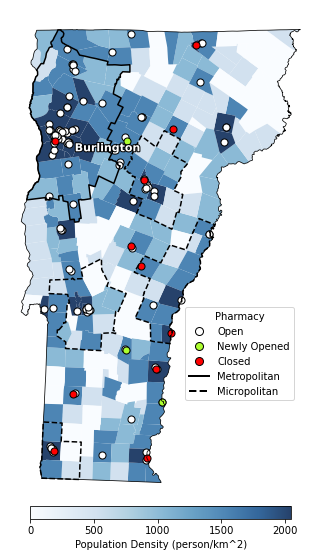

In [148]:
# Custom color map for pop density
base_cmap = plt.get_cmap('Blues')
num_colors = 256

custom_colors = []
for i in range(num_colors):
    color = colors.rgb_to_hsv(base_cmap(i)[:3])  # Convert RGB to HSV
    color[1] *= 0.7  # Reduce saturation by one third
    custom_colors.append(colors.hsv_to_rgb(color))  # Convert back to RGB

custom_cmap = colors.LinearSegmentedColormap.from_list("custom_blues", custom_colors, N=num_colors)

# Map Population Density
fig1, ax = plt.subplots(figsize=(12.3, 10.8))
mapping_df.plot(column='pop_density', scheme = 'jenkscaspallforced',k=5, cmap=custom_cmap, legend = False, ax=ax)

metropolitan_df = mapping_df[mapping_df['necta'] == 'Metropolitan']
micropolitan_df = mapping_df[mapping_df['necta'] == 'Micropolitan']

metropolitan_boundary = metropolitan_df.dissolve(by='necta')['geometry'].boundary
micropolitan_boundary = micropolitan_df.dissolve(by='necta')['geometry'].boundary

# Plot only the merged exterior boundaries of the 'Metropolitan NECTA' group
metropolitan_boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot only the merged exterior boundaries of the 'Micropolitan NECTA' group
micropolitan_boundary.plot(ax=ax, color='black', linestyle = 'dashed', linewidth=1.5)

vt_boundary = mapping_df.dissolve().boundary
vt_boundary.plot(ax=ax, color='black', linewidth=.75)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor='black', markersize=8, label='Open'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='greenyellow', markeredgecolor='black', markersize=8, label='Newly Opened'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', markersize=8, label='Closed'),
    Line2D([0], [0], color='black', lw=2, label='Metropolitan'),
    Line2D([0], [0], color='black', lw=2, linestyle= 'dashed', label='Micropolitan')
]

pd_colorbar = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=2046.6))
cbar = plt.colorbar(pd_colorbar, shrink = .38, pad=.001, label = 'Population Density (person/km^2)', location="bottom")
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, bbox_to_anchor=(.95,.2), title="Pharmacy")

pharmacies_map[pharmacies_map['status'] == 'open'].plot(ax=ax, marker='o', facecolor='white', edgecolor='black', markersize=50, label='Pharmacy')
pharmacies_map[pharmacies_map['status'] == 'closed'].plot(ax=ax, marker='o', facecolor='red', edgecolor='black', markersize=50, label='Pharmacy (Closed)')
pharmacies_map[pharmacies_map['status'] == 'opened'].plot(ax=ax, marker='o', facecolor='greenyellow', edgecolor='black', markersize=50, label='Pharmacy (New)')

plt.text(0.22, 0.71, 'Burlington', transform=ax.transAxes, size=11, weight="bold", color='white',
         path_effects=[path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

#fig.patch.set_edgecolor('black') #Border
#fig.patch.set_linewidth(2)

plt.axis('off')
plt.show()

#Export figure to results/figures
if figsave:
    fig1.savefig(make_fig_file(1), dpi=300)

**Figure 1**. Vermont study area with population density and pharmacy locations across the state. Metropolitan and micropolitan towns are outlined. 

### Hypothesis 1 - Spatial Dimension

Calculate mean access by NECTA type.

In [63]:
# Weekday accessibility by classification table
means_by_metro = mapping_df.groupby('necta').mean()
weekdaymean_by_metro = means_by_metro[['access_w']]

weekdaymean_by_metro.columns = ['Mean Access']
table_1 = tabulate(weekdaymean_by_metro, headers='keys', tablefmt='simple_grid')
print(table_1)

necta           Mean Access
------------  -------------
Metropolitan        4.19849
Micropolitan        4.2507
Rural               3.01231


#### Figure 2: Weekday accessibility

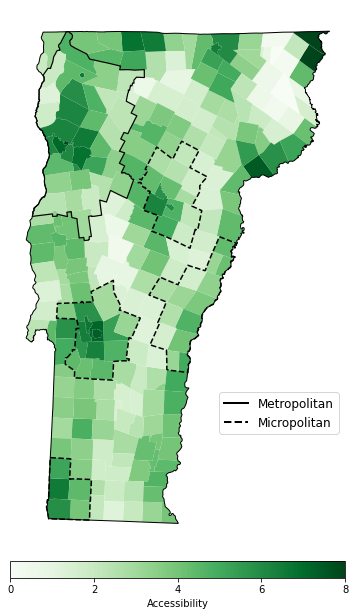

In [147]:
# set global maximum for mapping accessibility scores
if demand_population == "total_pop":
    maxacc = 8
else:
    maxacc = 25

# Map of weekday pharmacy accessibility
fig2, ax = plt.subplots(figsize=(12, 12), facecolor = 'white')
mapping_df.plot(column='access_w', cmap='Greens', legend = False, ax=ax, vmax=maxacc)
mapping_df.dissolve().boundary.plot(ax=ax, color='black', linewidth=1)

# Dissolve the geometries for each group to merge adjacent polygons 
metropolitan_df = mapping_df[mapping_df['necta'] == 'Metropolitan']
micropolitan_df = mapping_df[mapping_df['necta'] == 'Micropolitan']

metropolitan_boundary = metropolitan_df.dissolve(by='necta')['geometry'].boundary
micropolitan_boundary = micropolitan_df.dissolve(by='necta')['geometry'].boundary

# Plot exterior boundaries of the 'Metropolitan NECTA' group
metropolitan_boundary.plot(ax=ax, color='black', linewidth=1.2)

# Plot exterior boundaries of the 'Micropolitan NECTA' group
micropolitan_boundary.plot(ax=ax, color='black',linestyle = "dashed", linewidth=1.5)

legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Metropolitan'),
    Line2D([0], [0], color='black', linestyle = 'dashed',lw=2, label='Micropolitan')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=12, bbox_to_anchor=(1,.2))
colorbar = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=maxacc))

#fig.patch.set_edgecolor('black') #Border
#fig.patch.set_linewidth(2)  
#plt.subplots_adjust(right = .9, top = .9)

# Colorbar settings
cbar = plt.colorbar(colorbar, shrink = .5, pad=.02, label = 'Accessibility', location="bottom")

if demand_population == "total_pop":
    cbar.set_ticks([0, 2, 4, 6, 8])
else:
    cbar.set_ticks([0, 5, 10, 15, 20, 25])

    
plt.axis('off')
plt.show()

# Save figure
if figsave:
    fig2.savefig(make_fig_file(2), dpi=300)

**Figure 2.** Spatial accessibility during conventional weekday business hours, representing a time period when all pharmacies are operational (maximum accessibility). 

#### Statistical Significance

Not normal distribution. Cannot use ANOVA test. Use Kruskal-Wallis instead.


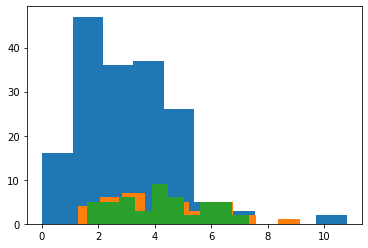

In [65]:
# Check for normal distribution in weekday metro, micro, rural
access_w_metro = mapping_df[mapping_df['necta'] == 'Metropolitan']['access_w']
access_w_micro = mapping_df[mapping_df['necta'] == 'Micropolitan']['access_w']
access_w_rural = mapping_df[mapping_df['necta'] == 'Rural']['access_w']

plt.hist(access_w_rural, bins=10)
plt.hist(access_w_metro, bins=10)
plt.hist(access_w_micro, bins=10)
print("Not normal distribution. Cannot use ANOVA test. Use Kruskal-Wallis instead.")

In [66]:
# Kruskal Wallis Test for significant difference of means between necta classification during conventional business hours
h_statistic_1, p_value_1 = kruskal(access_w_metro, access_w_micro, access_w_rural)
                 
print("Kruskal-Wallis H Statistic:", h_statistic_1)
print("P-value:", p_value_1)

alpha = 0.05
if p_value_1 < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean access during conventional weekday \nbusiness hours between metropolitan, micropolitan, and rural towns.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean access between groups.")

Kruskal-Wallis H Statistic: 27.690600217921656
P-value: 9.706497843353757e-07
Reject the null hypothesis. There is a significant difference in mean access during conventional weekday 
business hours between metropolitan, micropolitan, and rural towns.


In [67]:
dunn_data = np.concatenate([access_w_metro, access_w_micro, access_w_rural])
dunn_groups = ['access_w_metro']*len(access_w_metro) + ['access_w_micro']*len(access_w_micro) + ['access_w_rural']*len(access_w_rural)
dunn_df = pd.DataFrame({'value': dunn_data, 'group': dunn_groups})

# Perform Dunn's test with p-value adjustment (e.g., 'holm')
dunn_results = sp.posthoc_dunn(dunn_df, val_col='value', group_col='group', p_adjust='holm')
print("\nDunn's Post Hoc Test Results (p-values):\n", dunn_results)


Dunn's Post Hoc Test Results (p-values):
                 access_w_metro  access_w_micro  access_w_rural
access_w_metro        1.000000        0.647035        0.001077
access_w_micro        0.647035        1.000000        0.000016
access_w_rural        0.001077        0.000016        1.000000


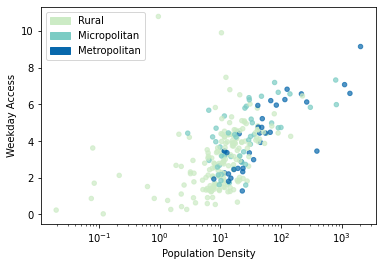

In [ ]:
# Create the scatter plot
import matplotlib.patches as mpatches

nectas = {'Rural': '#ccebc5',
          'Micropolitan': '#7bccc4', 
          'Metropolitan': '#0868ac'
          }

color_list = [nectas[group] for group in mapping_df['necta']]

legend_handles = []
for key, value in nectas.items():
    patch = mpatches.Patch(color=value, label=key)
    legend_handles.append(patch)

mapping_df.plot.scatter('pop_density', 'access_w', c=color_list, alpha=0.7)

# Add labels and title
plt.xlabel("Population Density")
plt.xscale('log')
plt.ylabel("Weekday Access")
plt.legend(handles=legend_handles)

Scatterplot of Population and Weekday Access to illustrate relationship between NECTA classification, population density of county subdivisions, and spatial accessibility.

### Hypothesis 2 - Temporal Dimension

Calculate mean access by type of day, and then map accessibility by county subdivision for each type of day.

In [68]:
# Mean accessibility by day table
mean_access_day = mapping_df[['access_w', 'access_s', 'access_su']].mean()
mean_access_day_df = mean_access_day.to_frame().rename(columns={0: 'Mean Access'})
mean_access_day_df.index = ['Weekday', 'Saturday', 'Sunday']
table_2 = tabulate(mean_access_day_df, headers='keys', tablefmt='simple_grid')
print(table_2)

            Mean Access
--------  -------------
Weekday         3.40823
Saturday        2.02426
Sunday          1.43059


#### Figure 3: Accessibility variation by day of the week

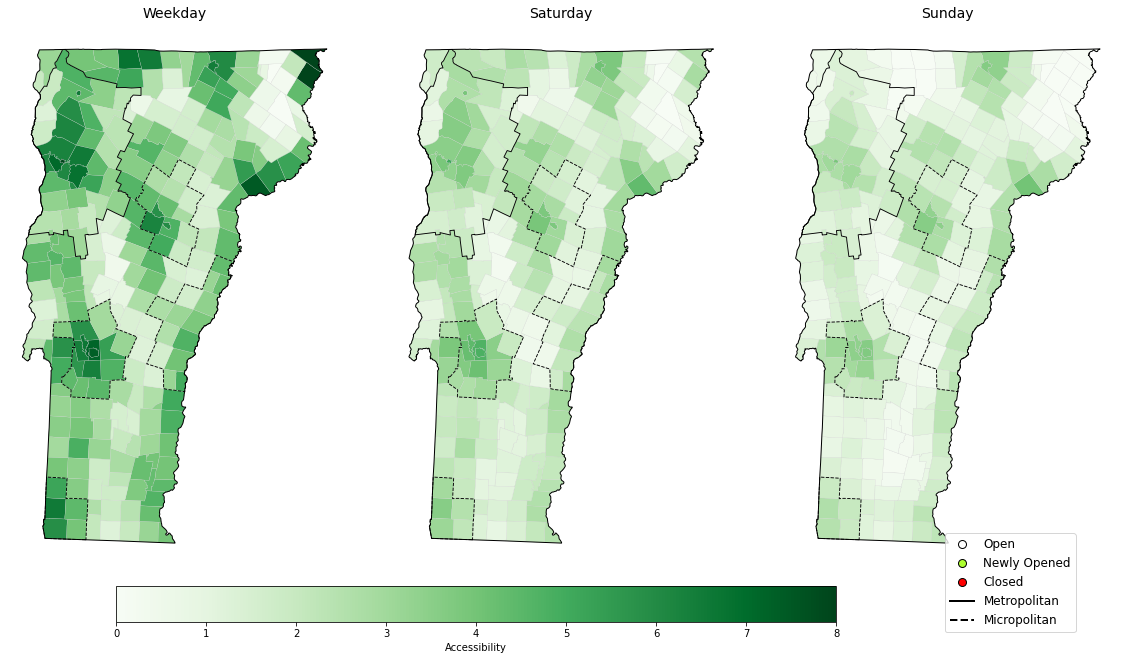

In [150]:
# Map accessibility by day of the week
mapping_df1 = mapping_df
#print(mapping_df1[['access_w', 'access_s', 'access_su']].min().min())  # Min accessibility value
#print(mapping_df1[['access_w', 'access_s', 'access_su']].max().max())  # Max accessibility value

fig3, axs = plt.subplots(1, 3, figsize=(22.5, 10), facecolor = 'white')
plt.subplots_adjust(wspace=-.4)

for i, column in enumerate(['access_w', 'access_s', 'access_su']):
    ax = axs[i]
    mapping_df1.plot(column=column, cmap='Greens', linewidth=0.2, ax=ax, edgecolor='0.8', legend=False,
                vmin=0, vmax=maxacc)
    mapping_df1.dissolve().boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Plot only the merged exterior boundaries of the 'Metropolitan NECTA' group
    metropolitan_boundary.plot(ax=ax, color='black', linewidth=.9)

    # Plot only the merged exterior boundaries of the 'Micropolitan NECTA' group
    micropolitan_boundary.plot(ax=ax, color='black', linestyle = 'dashed', linewidth=.9)
    
    axs[0].set_title(label='Weekday', fontsize=14)
    axs[1].set_title('Saturday', fontsize=14)
    axs[2].set_title('Sunday', fontsize=14)
    ax.axis('off')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=maxacc), cmap='Greens'), ax=axs, #Max was set to 20 for visualization purposes
                    orientation='horizontal', pad=.07, shrink=.5)
cbar.set_label('Accessibility')

#fig.patch.set_edgecolor('black') # Figure Border
#fig.patch.set_linewidth(2)       # Figure Border
plt.subplots_adjust(right=1)

cbar.ax.set_position([0.26, 0.05, .5, 0.05])

ax.legend(handles=legend_elements, loc='lower right', fontsize=12, bbox_to_anchor=(.9,-.129))

plt.show()

#Save Figure
if figsave:
    fig3.savefig(make_fig_file(3), dpi=300)

**Figure 3**. Spatial accessibility across days of the week. Each map represents the maximum accessibility on each day when all pharmacies that plan to open that day are operational. 

#### Figure 4: Accessibility by time of day

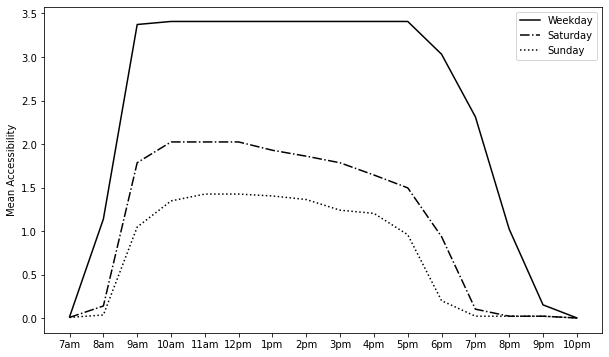

In [149]:
linegraph_df = mapping_df.copy()  

# Weekday
access_columns_w = ['access_7week','access_8week','access_9week','access_10week','access_11week','access_12week', 'access_13week','access_14week','access_15week','access_16week','access_17week','access_18week','access_19week', 'access_20week', 'access_21week', 'access_22week']
values_w = linegraph_df[access_columns_w].mean()  # Calculate the mean value for each access column

# Saturday
access_columns_s = ['access_7sat','access_8sat','access_9sat','access_10sat','access_11sat','access_12sat','access_13sat','access_14sat','access_15sat','access_16sat','access_17sat','access_18sat','access_19sat', 'access_20sat', 'access_21sat', 'access_22sat']
values_s = linegraph_df[access_columns_s].mean()  # Calculate the mean value for each access column

# Sunday
access_columns_su = ['access_7sun','access_8sun','access_9sun','access_10sun', 'access_11sun','access_12sun','access_13sun','access_14sun', 'access_15sun', 'access_16sun', 'access_17sun', 'access_18sun', 'access_19sun', 'access_20sun', 'access_21sun', 'access_22sun']
values_su = linegraph_df[access_columns_su].mean()  # Calculate the mean value for each access column

# X-axis values for all three days
common_x_values = ['7am', '8am', '9am', '10am', '11am','12pm','1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm']

# Plot together
fig4, ax = plt.subplots(figsize=(10, 6))
plt.plot(common_x_values, values_w, label='Weekday', color='black', linestyle='-')
plt.plot(common_x_values, values_s, label='Saturday', color='black', linestyle='-.')
plt.plot(common_x_values, values_su, label='Sunday', color='black', linestyle=':')
#plt.title('Access by Time of Day')
#plt.xlabel('Time of Day')
plt.ylabel('Mean Accessibility')
plt.xticks() 
plt.yticks()
plt.legend()
plt.show()

# save figure
if figsave:
    fig4.savefig(make_fig_file(4), dpi=300)

**Figure 4.** Mean accessibility throughout hours of the day, broken down by days of the week. 

#### Figure 5: Accessibility at extreme hours

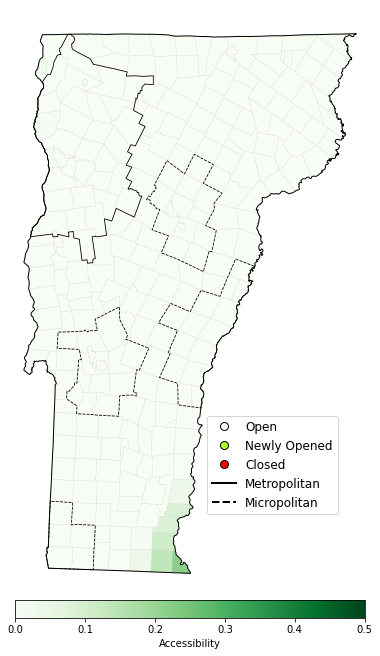

In [151]:
fig5, ax = plt.subplots(figsize=(10, 10), facecolor = "white")
mapping_df.plot(column='access_23week', cmap='Greens', ax=ax, linewidth=0.2, edgecolor= '.8', vmax=.5)
mapping_df.dissolve().boundary.plot(ax=ax, color='black', linewidth=1)

cb = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=.5))
#cbar = plt.colorbar(cb, shrink = .5, orientation = 'horizontal', pad=0, label = 'Accessibility')

metropolitan_boundary.plot(ax=ax, color='black', linewidth=.8)
micropolitan_boundary.plot(ax=ax, color='black',linestyle = "dashed", linewidth=.8)

#fig.patch.set_edgecolor('black') #Border
#fig.patch.set_linewidth(2)  
plt.subplots_adjust(right = .5, top = .9)

# Colorbar and Legend
cbar = plt.colorbar(cb, shrink = .5, orientation = 'horizontal', pad=0, label = 'Accessibility')
ax.legend(handles=legend_elements, loc='lower right', fontsize=12, bbox_to_anchor=(.92,.135))

plt.axis('off')
plt.tight_layout()
plt.show()

# Save Figure
if figsave:
    fig5.savefig(make_fig_file(5), dpi=300)

**Figure 5.** Late night accessibility. Represents access between 10 pm and 7 am. 

#### Statistical Significance

Distribution is not normal. Cannot use ANOVA test. Use Kruskal-Wallis instead.


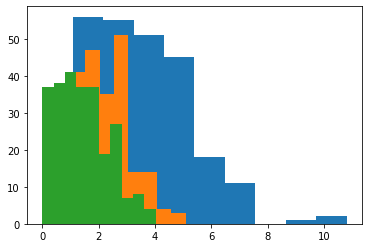

In [72]:
access_w_test = pd.Series(mapping_df['access_w'])
access_s_test = pd.Series(mapping_df['access_s'])
access_su_test = pd.Series(mapping_df['access_su'])

# Check for distribution between days of week. 
plt.hist(access_w_test, bins=10) 
plt.hist(access_s_test , bins=10) 
plt.hist(access_su_test, bins=10) 
print("Distribution is not normal. Cannot use ANOVA test. Use Kruskal-Wallis instead.")

In [73]:
# Run Kruskal-Wallis Test
h_statistic_2, p_value_2 = kruskal(access_w_test, access_s_test, access_su_test)
                 
print("Kruskal-Wallis H Statistic:", h_statistic_2)
print("P-value:", p_value_2)

alpha = 0.05
if p_value_2 < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean access between weekdays, Saturdays, and Sundays.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean access between days.")
                    

Kruskal-Wallis H Statistic: 202.67482244348162
P-value: 9.76610740072804e-45
Reject the null hypothesis. There is a significant difference in mean access between weekdays, Saturdays, and Sundays.


In [74]:
dunn_data = np.concatenate([access_w_test, access_s_test, access_su_test])
dunn_groups = ['access_w_test']*len(access_w_test) + ['access_s_test']*len(access_s_test) + ['access_su_test']*len(access_su_test)
dunn_df = pd.DataFrame({'value': dunn_data, 'group': dunn_groups})

# Perform Dunn's test with p-value adjustment (e.g., 'holm')
dunn_results = sp.posthoc_dunn(dunn_df, val_col='value', group_col='group', p_adjust='holm')
print("\nDunn's Post Hoc Test Results (p-values):\n", dunn_results)


Dunn's Post Hoc Test Results (p-values):
                 access_s_test  access_su_test  access_w_test
access_s_test    1.000000e+00    1.463181e-08   4.593845e-17
access_su_test   1.463181e-08    1.000000e+00   6.143013e-45
access_w_test    4.593845e-17    6.143013e-45   1.000000e+00


### Hypothesis 3 - Spatio-Temporal Dynamics

Calculate mean access by NECTA classification and type of day. Simplify NECTA classification to rural and urban categories by merging micropolitan and metropolitan into "urban". Then calculate the percentage change from urban to rural for each type of day by finding the normalized percent difference with:  
`(Metro - Micro Access) / (Metro + Micro) * 100`  
`(Metro - Rural Access) / (Metro + Rural) * 100`  
`(Micro - Rural Access) / (Micro + Rural) * 100`

In [129]:
# Accessibility by Day and metropolitan/micropolitan Table
means_by_metro = mapping_df.groupby('necta').mean()[['access_w','access_s','access_su']]
means_by_metro = means_by_metro.rename(columns={"access_w": "Weekday", 
                                                "access_s": "Saturday",
                                                "access_su": "Sunday"})
means_by_metro = means_by_metro.transpose()
means_by_metro = means_by_metro.rename(columns={"Metropolitan": "Metro", 
                                                "Micropolitan": "Micro"})

def pctdiff(df, col1, col2):
    newcol = col1 + "_" + col2
    df[newcol] = (df[col1] - df[col2])/(df[col1] + df[col2]) * 100
    return df

means_by_metro = round(pctdiff(means_by_metro, "Metro", "Micro"), 2)
means_by_metro = round(pctdiff(means_by_metro, "Metro", "Rural"), 2)
means_by_metro = round(pctdiff(means_by_metro, "Micro", "Rural"), 2)

means_by_metro

# print(tabulate(means_by_metro, tablefmt = 'fancy_grid', headers=["","N","Weekday Mean Access", "Saturday Mean Access", "Sunday Mean Access"]))
#means_by_metro

necta,Metro,Micro,Rural,Metro_Micro,Metro_Rural,Micro_Rural
Weekday,4.20,4.25,3.01,-0.62,16.50,17.08
Saturday,2.45,2.65,1.76,-3.86,16.39,20.18
Sunday,1.70,2.14,1.18,-11.55,18.06,28.92


**Table 1.** Mean Accessibility on weekdays, Saturdays, and Sundays, broken down by non-rural and rural subdivisions. Percent differences are calculated to see how accessibility gaps differ throughout the week. 

#### Figure 7: Time of day and NECTA classification

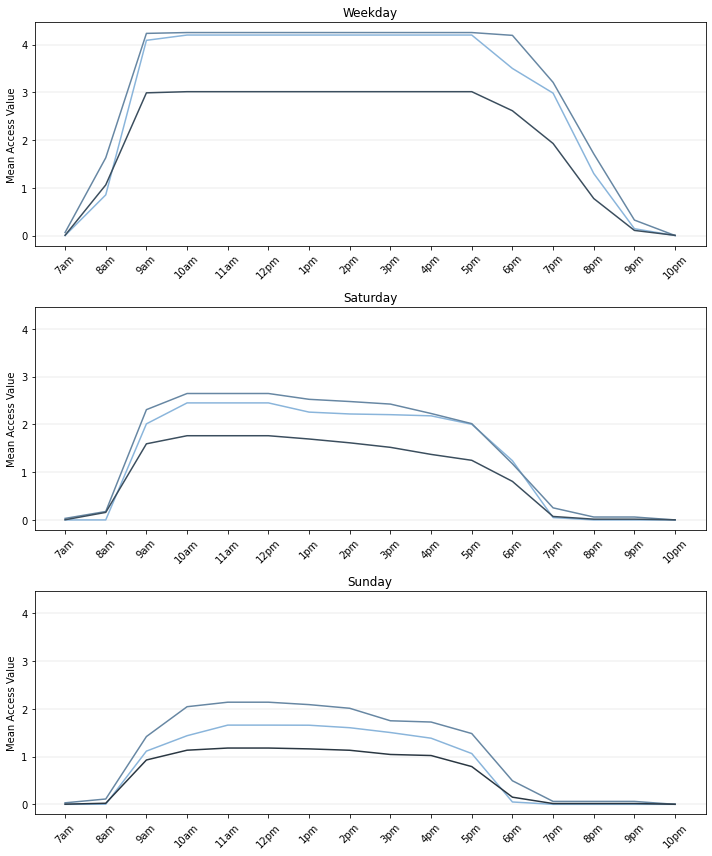

In [152]:
access_columns = ['access_7week','access_8week','access_9week','access_10week','access_11week','access_12week',
                  'access_13week','access_14week','access_15week','access_16week','access_17week','access_18week',
                  'access_19week', 'access_20week', 'access_21week', 'access_22week']
linegraph_df2 = mapping_df.groupby('necta')[access_columns].mean()
linegraph_df2 = linegraph_df2.T

access_columns2 = ['access_7sat','access_8sat','access_9sat','access_10sat','access_11sat','access_12sat',
                   'access_13sat','access_14sat','access_15sat','access_16sat','access_17sat','access_18sat',
                   'access_19sat', 'access_20sat', 'access_21sat', 'access_22sat']
linegraph_df3 = mapping_df.groupby('necta')[access_columns2].mean()
linegraph_df3 = linegraph_df3.T

access_columns3 = ['access_7sun','access_8sun','access_9sun','access_10sun', 'access_11sun','access_12sun',
                   'access_13sun','access_14sun', 'access_15sun', 'access_16sun', 'access_17sun', 'access_18sun', 
                   'access_19sun', 'access_20sun', 'access_21sun', 'access_22sun']
linegraph_df4 = mapping_df.groupby('necta')[access_columns3].mean()
linegraph_df4 = linegraph_df4.T

fig7, axs = plt.subplots(3, 1, figsize=(10, 12), sharey = True)  

custom_ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
time_labels = ['7am','8am', '9am','10am','11am','12pm','1pm','2pm', '3pm','4pm','5pm','6pm', '7pm','8pm','9pm','10pm']


# Weekday 
linegraph_df2.plot(time_labels, kind='line', color= ['#8AB5DB','#6787A3','#3B4E5E'] , ax=axs[0], legend = None)  
axs[0].set_title('Weekday')
axs[0].set_xlabel('')
axs[0].set_ylabel('Mean Access Value')
axs[0].set_xticks(custom_ticks)  
axs[0].set_xticklabels(time_labels, rotation= 45) 
axs[0].grid(axis='y', linestyle='-', linewidth=0.08, color='black')

# Saturday
linegraph_df3.plot(time_labels, kind='line', color = ['#8AB5DB','#6787A3','#3B4E5E'] , ax=axs[1], legend = None) 
axs[1].set_title('Saturday')
axs[1].set_xlabel('')
axs[1].set_ylabel('Mean Access Value')
axs[1].set_xticks(custom_ticks) 
axs[1].set_xticklabels(time_labels, rotation = 45) 
axs[1].grid(axis='y', linestyle='-', linewidth=0.08, color='black')

# Sunday
linegraph_df4.plot(time_labels, kind='line', color = ['#8AB5DB','#6787A3','#2A3742'], ax=axs[2], legend= None)  
axs[2].set_title('Sunday')
axs[2].set_xlabel('')
axs[2].set_ylabel('Mean Access Value')
axs[2].set_xticks(custom_ticks)  
axs[2].set_xticklabels(time_labels, rotation = 45) 
axs[2].grid(axis='y', linestyle='-', linewidth=0.08, color='black')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12, title='', title_fontsize='large', labels = ['Metropolitan','Micropolitan','Rural'], bbox_to_anchor=(0.5, -0.04))

#fig.patch.set_edgecolor('black') #Border
#fig.patch.set_linewidth(2)  

#plt.suptitle('Mean Access by Time of Day', x=0.51, y=1.0, fontsize=16, ha='center')
plt.tight_layout()
plt.show()

# Save Figure
if figsave:
    fig7.savefig(make_fig_file(7), dpi=300)

**Figure 7.** Mean Accessibility across hours of the day for weekdays, Saturdays, and Sundays by NECTA classification. 

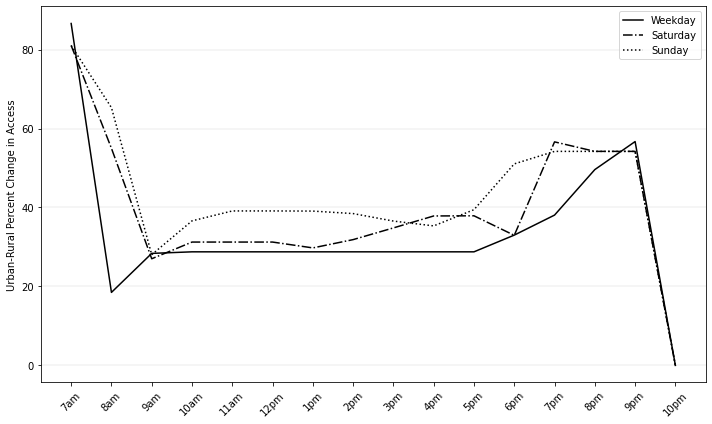

In [153]:
# WEEKDAY
mapping_df['necta'].fillna('Rural', inplace=True)

access_columns = ['access_7week','access_8week','access_9week','access_10week','access_11week',
                  'access_12week', 'access_13week','access_14week','access_15week','access_16week',
                  'access_17week','access_18week','access_19week', 'access_20week', 'access_21week', 
                  'access_22week']

hourly_diff_df = mapping_df.groupby('necta')[access_columns].mean() # Mean access by hour of the day after grouping by NECTA
hourly_diff_df = hourly_diff_df.T
hourly_diff_df['Non-rural'] = (hourly_diff_df['Metropolitan'] * 35 + hourly_diff_df['Micropolitan'] * 48) / (35 + 48) #weighted average to 
hourly_diff_df['%_diff'] = ((hourly_diff_df['Rural'] - hourly_diff_df['Non-rural']) / hourly_diff_df['Non-rural']) * 100 #Percent diff between rural and non-rural
hourly_diff_df['%_diff']['access_22week']=0 #Make this value 0. Both accessibility values too small to take meaningful % difference. Both values virtually 0 access
hourly_diff_df['%_diff'] = hourly_diff_df['%_diff'].abs() #Take absolute value for plotting
hourly_diff_df

# SATURDAY
access_columns2 = ['access_7sat','access_8sat','access_9sat','access_10sat','access_11sat','access_12sat',
                   'access_13sat','access_14sat','access_15sat','access_16sat','access_17sat','access_18sat',
                   'access_19sat', 'access_20sat', 'access_21sat', 'access_22sat']

hourly_diff_df2 = mapping_df.groupby('necta')[access_columns2].mean() # Mean access by hour of the day after grouping by NECTA
hourly_diff_df2 = hourly_diff_df2.T
hourly_diff_df2['Non-rural'] = (hourly_diff_df2['Metropolitan'] * 35 + hourly_diff_df2['Micropolitan'] * 48) / (35 + 48) #weighted average to 
hourly_diff_df2['%_diff'] = ((hourly_diff_df2['Rural'] - hourly_diff_df2['Non-rural']) / hourly_diff_df2['Non-rural']) * 100 #Percent diff between rural and non-rural
hourly_diff_df2['%_diff']['access_22sat']=0 #Make this value 0. Both accessibility values too small to take meaningful % difference. Both values virtually 0 access
hourly_diff_df2['%_diff'] = hourly_diff_df2['%_diff'].abs() #Take absolute value for plotting
hourly_diff_df2

# SUN
access_columns3 = ['access_7sun','access_8sun','access_9sun','access_10sun', 'access_11sun','access_12sun',
                   'access_13sun','access_14sun', 'access_15sun', 'access_16sun', 'access_17sun', 'access_18sun', 
                   'access_19sun', 'access_20sun', 'access_21sun', 'access_22sun']

hourly_diff_df3 = mapping_df.groupby('necta')[access_columns3].mean() # Mean access by hour of the day after grouping by NECTA
hourly_diff_df3 = hourly_diff_df3.T
hourly_diff_df3['Non-rural'] = (hourly_diff_df3['Metropolitan'] * 35 + hourly_diff_df3['Micropolitan'] * 48) / (35 + 48) #weighted average to 
hourly_diff_df3['%_diff'] = ((hourly_diff_df3['Rural'] - hourly_diff_df3['Non-rural']) / hourly_diff_df3['Non-rural']) * 100 #Percent diff between rural and non-rural
hourly_diff_df3['%_diff']['access_22sun']=0 #Make this value 0. Both accessibility values too small to take meaningful % difference. Both values virtually 0 access
hourly_diff_df3['%_diff'] = hourly_diff_df3['%_diff'].abs() #Take absolute value for plotting
hourly_diff_df3

common_x_values = ['7am', '8am', '9am', '10am', '11am','12pm','1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm']

# PLOT TOGETHER
fig8 = plt.figure(figsize=(10, 6))
plt.plot(common_x_values, hourly_diff_df['%_diff'], label='Weekday', color = 'black',linestyle='-')
plt.plot(common_x_values, hourly_diff_df2['%_diff'], label='Saturday', color = 'black', linestyle='-.')
plt.plot(common_x_values, hourly_diff_df3['%_diff'], label='Sunday', color = 'black', linestyle=':')

plt.ylabel('Urban-Rural Percent Change in Access')
plt.grid(axis='y', linestyle='-', linewidth=0.08, color='black')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Save Figure
if figsave:
    fig8.savefig(make_fig_file(8), dpi=300)

**Figure 8.** Percent difference in mean accessibility scores across hours of the day between rural and urban areas by day of the week.